In [ ]:
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width, img_height=192,192
input_shape=(img_height,img_width)
train_data_dir='/content/drive/MyDrive/Explicit_Content Dataset/data'



In [ ]:
batch_size=16;
#Data augmentation
datagen=ImageDataGenerator(
    rescale=1./244,
    validation_split=0.20,
)
train_generator=datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    subset="training",
    class_mode='binary'   
)
val_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    subset="validation",
    class_mode='binary'

)

In [ ]:
# test_data_dir='/content/drive/MyDrive/vali_ex/'
# test_generator = datagen.flow_from_directory(
#         test_data_dir,
#         target_size=(img_width,img_height),
#         batch_size=batch_size,
#         class_mode='binary',
#         shuffle=True)

In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
# from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(192, 192, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(192, 192, 3))

In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)
# model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
# opt = Adam(0.01)
opt = Adam(0.000001)
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
from keras.callbacks import History,ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("/content/drive/MyDrive/Explicit_Content Dataset/", monitor='accuracy', verbose=1, save_best_only=True,
#                              save_weights_only=False)
history=History()
model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,callbacks=[history],
    validation_data=test_generator
    # validation_steps=2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
100/100 [==============================] - 1924s 19s/step - loss: 0.6870 - accuracy: 0.5763 - val_loss: 0.7132 - val_accuracy: 0.4843
Epoch 2/50
100/100 [==============================] - 551s 6s/step - loss: 0.6744 - accuracy: 0.5987 - val_loss: 0.7088 - val_accuracy: 0.4843
Epoch 3/50
100/100 [==============================] - 513s 5s/step - loss: 0.6630 - accuracy: 0.6050 - val_loss: 0.6884 - val_accuracy: 0.5366
Epoch 4/50
100/100 [==============================] - 482s 5s/step - loss: 0.6625 - accuracy: 0.5950 - val_loss: 0.6819 - val_accuracy: 0.5483
Epoch 5/50
100/100 [==============================] - 445s 4s/step - loss: 0.6518 - accuracy: 0.6075 - val_loss: 0.6585 - val_accuracy: 0.6023
Epoch 6/50
100/100 [==============================] - 444s 4s/step - loss: 0.6426 - accuracy: 0.6100 - val_loss: 0.7200 - val_accuracy: 0.5286
Epoch 7/50
100/100 [==============================] - 414s 4s/step - loss: 0.6237 - accuracy: 0.6616 - val_loss: 0.6479 - val_accuracy: 0.60

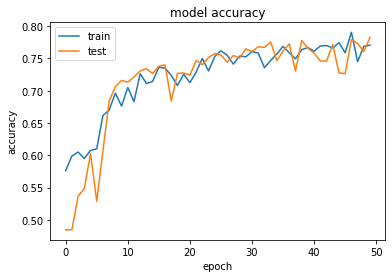

In [ ]:
#summarize History
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

Text(0.5, 1.0, 'Loss Curves')

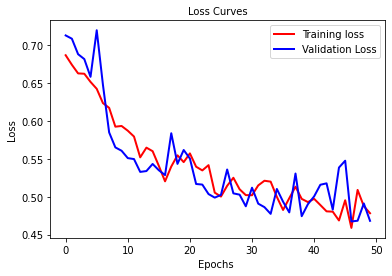

In [ ]:
# Loss Curves
#plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
#plt.grid()
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)

In [ ]:
from keras.callbacks import History,ModelCheckpoint, EarlyStopping
# checkpoint = ModelCheckpoint("/content/drive/MyDrive/Explicit_Content Dataset/", monitor='accuracy', verbose=1, save_best_only=True,
#                              save_weights_only=False)
history=History()
model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=50,callbacks=[history],
    validation_data=validation_generator
    # validation_steps=2
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
30/30 [==============================] - 1007s 34s/step - loss: 0.6705 - accuracy: 0.6083 - val_loss: 0.6952 - val_accuracy: 0.4718
Epoch 2/50
30/30 [==============================] - 185s 6s/step - loss: 0.7010 - accuracy: 0.5979 - val_loss: 0.6955 - val_accuracy: 0.4718
Epoch 3/50
30/30 [==============================] - 178s 6s/step - loss: 0.7234 - accuracy: 0.5542 - val_loss: 0.6985 - val_accuracy: 0.4718
Epoch 4/50
30/30 [==============================] - 180s 6s/step - loss: 0.6645 - accuracy: 0.6000 - val_loss: 0.7031 - val_accuracy: 0.4718
Epoch 5/50
30/30 [==============================] - 168s 6s/step - loss: 0.6926 - accuracy: 0.5542 - val_loss: 0.6982 - val_accuracy: 0.4695
Epoch 6/50
30/30 [==============================] - 168s 6s/step - loss: 0.6459 - accuracy: 0.6125 - val_loss: 0.7160 - val_accuracy: 0.4718
Epoch 7/50
30/30 [==============================] - 162s 5s/step - loss: 0.6542 - accuracy: 0.5813 - val_loss: 0.7574 - val_accuracy: 0.4718
Epoch 8/50


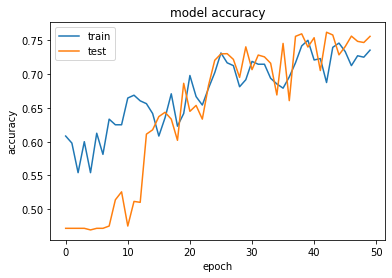

In [ ]:
#summarize History
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

Text(0.5, 1.0, 'Loss Curves')

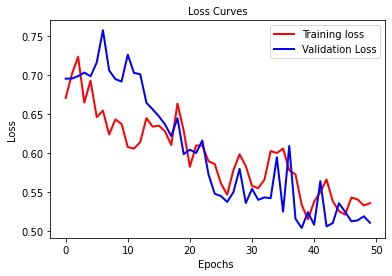

In [ ]:
# Loss Curves
#plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=10)
#plt.grid()
plt.xlabel('Epochs ',fontsize=10)
plt.ylabel('Loss',fontsize=10)
plt.title('Loss Curves',fontsize=10)
 

In [ ]:
Test_data_dir='/content/drive/MyDrive/test/'
Test_generator = datagen.flow_from_directory(
        Test_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

In [ ]:
result = model.evaluate(Test_generator ,batch_size=batch_size)
print("test_loss, test accuracy",result)

In [ ]:
class_labels = Test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [ ]:
y_pred = model.predict_generator(Test_generator)
# y_pred_label = np.argmax(y_pred, axis=1)
Test_generator.classes.shape,y_pred_label.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.
